## super resolution using bSSFP
###### Author: Zimu Huo
###### Date: 02.2022


All code presented is **translated** from Peter lally's matlab scripts, 
for more detailed information check https://github.com/petelally/SuperOffRes.git<br>
(cite the paper if you are using it :D)

(my learning)Road map: SPAMM -> micro SPAMM -> phaseless encoding -> subpixel encoding -> super offres 

The idea in general is to use a series of low res images each with a unique tagging pattern to reconstruct higher resolution image<br>

1. The original SPAMM paper uses spatial modulation to tag the cardiac motion
2. micro SPAMM uses the technique from SPAMM and applies sinusoidal spatial modulations in order to achieve super resolution 
3. Phaseless encoding uses phaseless sinusoidal spatial modulations 
4. super off resolution uses properties of the bSSFP to achieve super resolution 

Encoding means times a function in one domian(convolution in the other).<br>
Take phaseless encoding for example, it uses sinusoidal modulations in the time domain, which means convolving with two Dirac deltas in fourier domain <br>
-> wider in fourier -> thinner in image domain -> higher resolution. 

-------------------------------------------------------------------------
References
    
    [1] 
    Author: Peter J. Lally et al. 
    Title: Unbalanced SSFP for super-resolution in MRI
    Link: https://onlinelibrary.wiley.com/doi/10.1002/mrm.28593
    
    [2] 
    Author: Axel L, Dougherty L et al. 
    Title: MR imaging of motion with spatial modulation of magnetization. 
    Link: https://mriquestions.com/uploads/3/4/5/7/34572113/radiology2e1712e32e2717762.pdf
    
    [3] 
    Author: Stefan Ropele et al. 
    Title: Super-Resolution MRI Using Microscopic Spatial Modulation of Magnetization
    Link: https://mriquestions.com/uploads/3/4/5/7/34572113/radiology2e1712e32e2717762.pdf
    
    [4] 
    Author: Franciszek Hennel L et al. 
    Title: MRI With Phaseless Encoding
    Link: https://pubmed.ncbi.nlm.nih.gov/27774644/

In [1]:
import numpy as np
from scipy import io
import math
import numpy.matlib
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../')
import lib.util.fft as fft

In [2]:
raw =  io.loadmat('../lib/resource/data/offRes/complexFID.mat')
ComplexFID = raw.get('complexFID')

In [4]:
[N1, N2, N3] = ComplexFID.shape
n_asym_bands=int((N3/2)+1) 
frq_offs= 2
S_bands=np.zeros([N1,N2,n_asym_bands], dtype= complex)
Im_mf=np.zeros([N1*N3,N2,frq_offs], dtype = complex)
print(n_asym_bands)
print(S_bands.shape)
print(Im_mf.shape)

19
(32, 128, 19)
(1152, 128, 2)


In [11]:
indexd1 = np.arange(int(N1/2),n_asym_bands*N1 +1, 1) -1 
indexd2 = np.arange(int(N1/2)+1,n_asym_bands*N1-N1,1) - 1 # change latter 
Im_mf= np.zeros([len(np.append(indexd1,indexd2)),int(N2),frq_offs], dtype = complex)
for frq in range(1,frq_offs+1):
    phases = 2*math.pi*np.arange(N3)/N3
    phases= phases+frq/frq_offs*2*math.pi
    phases = phases.reshape(-1,1)
    psi=np.exp(-1J*(np.arange(1,n_asym_bands+1).reshape(1,-1, order = 'F'))*phases)
    print(frq)
    for pix_a in range(N1):
        for pix_b in range(N2):
            S_bands[pix_a,pix_b,:] = np.squeeze(np.linalg.lstsq(psi, ComplexFID[pix_a,pix_b,:].reshape(-1,1,order = 'F'))[0])
            # this matrix inverse takes insanely long time to run 
            S_asym = np.zeros([n_asym_bands*N1,N2], dtype = complex)
            for k in range(1, n_asym_bands+1):
                S_asym[(k-1)*N1:k*N1,:] = S_bands[:,:,n_asym_bands-k]
            index1 = np.arange(int(N1/2),n_asym_bands*N1 +1, 1) -1 
            firsthalf = S_asym[index1,:]
            index2 = np.arange(int(N1/2)+1,n_asym_bands*N1-N1,1) - 1
            secondhalf = np.rot90(np.conj(S_asym[index2,:]), k=2)
            S = np.append(firsthalf, secondhalf).reshape(len(np.append(index1,index2)),N2)
            Im_mf[:,:,frq-1] = np.fft.fftshift(fft.ifft2c(S))

1


/var/folders/5d/6p36mvb505x5j7b_90jtxdsr0000gn/T/ipykernel_74824/3918897769.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  S_bands[pix_a,pix_b,:] = np.squeeze(np.linalg.lstsq(psi, ComplexFID[pix_a,pix_b,:].reshape(-1,1,order = 'F'))[0])


2


In [12]:
centvox=int(N1*N3/2)
bandw=np.arange(-int(N1/2),int(N1/2))
zf_mat=np.zeros((Im_mf[:,:,0].shape))
zf_mat[centvox+bandw,:]=1
size = np.append(np.asarray(zf_mat.shape),frq_offs)
Im_zf=fft.ifft2c(fft.fft2c(Im_mf)*np.matlib.repmat(zf_mat,1,frq_offs).reshape(size))

In [13]:
opt_off=numpy.amin((np.abs(np.angle(Im_zf))), axis =2)

In [14]:
Im_recon=np.zeros(Im_mf[:,:,1].shape, dtype = complex)
[A, B, C] = Im_mf.shape
for pix_a in range(A):
    for pix_b in range(B):    
        mod = np.int(np.mod(opt_off[pix_a,pix_b]-1,frq_offs))
        Im_recon[pix_a,pix_b]=Im_mf[pix_a, pix_b, mod]
    

/var/folders/5d/6p36mvb505x5j7b_90jtxdsr0000gn/T/ipykernel_74824/2823923257.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mod = np.int(np.mod(opt_off[pix_a,pix_b]-1,frq_offs))


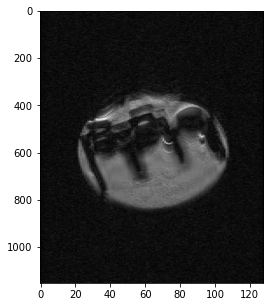

In [15]:
plt.figure(figsize=(4,5))
plt.imshow(np.abs(Im_recon),aspect='auto', cmap ="gray")
plt.show()